In [1]:
import torch_geometric
import networkx as nx
from networkx.drawing.nx_agraph import to_agraph 
from networkx.drawing.nx_agraph import write_dot
import matplotlib.pyplot as plt

G = nx.MultiDiGraph()
G.add_node(0, x=0.0, y=0.0, pos=(0.0,0.0))
G.add_node(1, x=2.0, y=1.0, pos=(1.0,1.0))
G.add_node(2, x=2.0, y=-1., pos=(1.0,-1.0))
G.add_node(3, x=4.0, y=1.0, pos=(2.0,1.0))
G.add_node(4, x=4.0, y=-1., pos=(2.0,-1.0))
G.add_node(5, x=6.0, y=0.0, pos=(3.0,0.0))


edge_index = [[0, 0, 1, 1, 2, 3, 4, 1, 2, 3, 4, 4, 5, 5],
              [1, 2, 3, 4, 4, 5, 5, 0, 0, 1, 1, 2, 3, 4]]
capacity = [1, 1, 1, 1, 1, 1, 1,
            0, 0, 0, 0, 0, 0, 0]

for u,v, cap in zip(edge_index[0], edge_index[1], capacity):
    G.add_edge(u, v, label=cap, color='black')
    
for n in G:
    G.nodes[n]['pos'] = "{},{}!".format(
        G.nodes[n]['x'], G.nodes[n]['y'])


write_dot(G, 'graph.dot')

In [2]:
!neato -T png graph.dot > graph.png

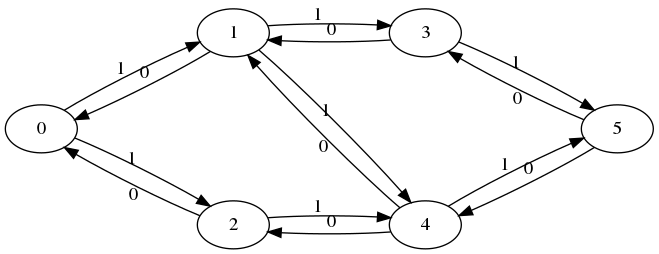

In [3]:
from IPython.display import Image, display
Image(filename='graph.png') 

In [4]:
from flow_datasets import GraphOnlyDataset, GraphOnlyDatasetBFS, SingleIterationDataset
from torch_geometric.data import Dataset, Data, Batch
import torch
import models
import utils

x=torch.cat((torch.full((6, 5, 1), 255), torch.full((6, 5, 1), -1)), dim=-1)
x[0][0][0]=0
x[0][0][1]=0
x
y=x.clone()
tcaps = torch.tensor(capacity, dtype=torch.float)
tweights = torch.randint_like(tcaps, 1, 16, dtype=torch.float)
tweights
edge_attr=torch.cat((tweights.unsqueeze(-1), tcaps.unsqueeze(-1)), dim=1)
tedge_index = torch.tensor(edge_index)
tedge_index.shape
inp = Data(x=x, y=y, edge_index=tedge_index, edge_attr=edge_attr)
batch = Batch.from_data_list([inp])
x_bfs=torch.full((6,5), 0, dtype=torch.float)
x_bfs[0][0]=1
y_bfs = x_bfs.clone()
inp_bfs = Data(x=x_bfs, y=y_bfs, edge_index=tedge_index, edge_attr=edge_attr)
batch_bfs = Batch.from_data_list([inp_bfs])
print(batch_bfs.edge_attr)


DIM_LATENT=32
DEVICE='cpu'
processor = models.AlgorithmProcessor(DIM_LATENT, SingleIterationDataset, 'MPNN').to(DEVICE)
utils.load_algorithms(['BFS', 'AugmentingPath'], processor, True)

processor.load_state_dict(torch.load('./models_to_test/MPNN/AugmentingPathPlusBFS/test_MPNNAugmentingPathPlusBFS_epoch_49.pt'))
processor.eval()
processor.to('cpu')

tensor([[12.,  1.],
        [ 3.,  1.],
        [ 4.,  1.],
        [ 6.,  1.],
        [ 8.,  1.],
        [10.,  1.],
        [ 6.,  1.],
        [ 3.,  0.],
        [ 1.,  0.],
        [13.,  0.],
        [13.,  0.],
        [ 9.,  0.],
        [13.,  0.],
        [ 4.,  0.]])


AlgorithmProcessor(
  (processor): MPNN(
    (M): Sequential(
      (0): Linear(in_features=96, out_features=32, bias=False)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (U): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=False)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (gru): GRUCell(32, 32, bias=False)
  )
  (algorithms): ModuleDict(
    (BFS): BFSNetwork(
      (processor): MPNN(
        (M): Sequential(
          (0): Linear(in_features=96, out_features=32, bias=False)
          (1): LeakyReLU(negative_slope=0.01)
        )
        (U): Sequential(
          (0): Linear(in_features=64, out_features=32, bias=False)
          (1): LeakyReLU(negative_slope=0.01)
        )
        (gru): GRUCell(32, 32, bias=False)
      )
      (decoder_network): DecoderNetwork(
        (output_net): Sequential(
          (0): Linear(in_features=64, out_features=1, bias=False)
        )
      )
      (termination_network): Sequential(
        (0): Linear(in_featur

Sink reachable! Step 1
Predecessors tensor([0, 0, 0, 1, 1, 4])
Path tensor([0, 1, 4, 5])
Path pair (tensor(0), tensor(1))
Path pair (tensor(1), tensor(4))
Path pair (tensor(4), tensor(5))


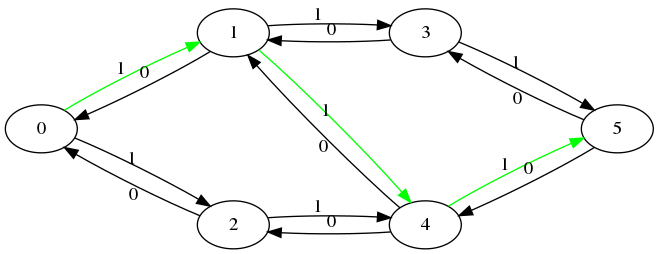

Neural bottleneck capacity: tensor([1.])
Real bottleneck capacity: tensor([1])
The graph after augment is


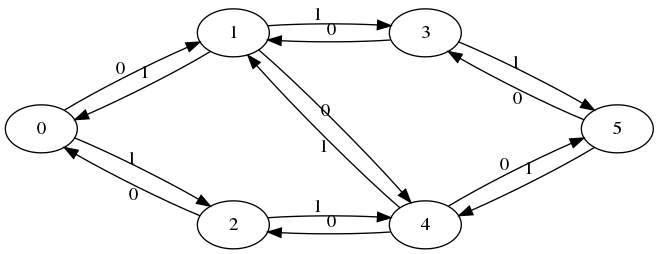

Sink reachable! Step 2
Predecessors tensor([0, 4, 0, 1, 2, 3])
Path tensor([0, 2, 4, 1, 3, 5])
Path pair (tensor(0), tensor(2))
Path pair (tensor(2), tensor(4))
Path pair (tensor(4), tensor(1))
Path pair (tensor(1), tensor(3))
Path pair (tensor(3), tensor(5))


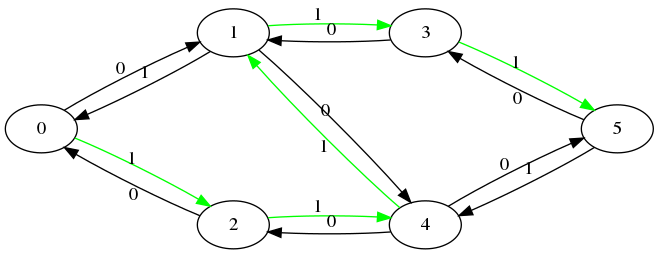

Neural bottleneck capacity: tensor([1.])
Real bottleneck capacity: tensor([1])
The graph after augment is


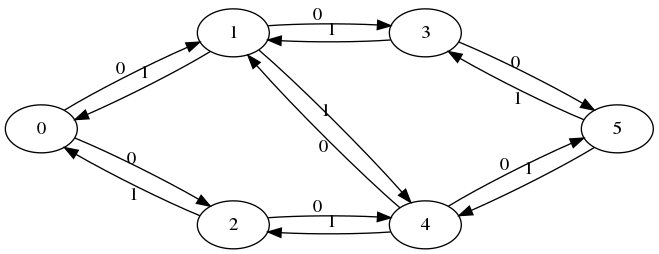

Sink no longer reachable. Terminate!


In [5]:
from half_deterministic import reweight_batch, augment_flow, obtain_paths, get_bottleneck, get_pairs
from copy import deepcopy
import os
GRAPH_SIZES, SOURCE_NODES, SINK_NODES = utils.get_sizes_and_source_sink(batch)
STEPS_SIZE = GRAPH_SIZES.max()
inv_edge_index = utils.create_inv_edge_index(len(GRAPH_SIZES), GRAPH_SIZES.max(), batch.edge_index)
redo_mask=torch.ones(1, dtype=torch.bool).cpu()

for algorithm in processor.algorithms.values():
    algorithm.zero_validation_stats()


reachable = processor.algorithms["BFS"].process(
    batch_bfs,
    EPSILON=0,
    enforced_mask=redo_mask,
    compute_losses_and_broken=False
)
step_cnt=1
do_not_process = torch.zeros_like(SINK_NODES, dtype=torch.bool)
while reachable[SINK_NODES].all():
    print("Sink reachable! Step {}".format(step_cnt))
    
    weights = batch.edge_attr[:, 0]
    flow = batch.edge_attr[:, 1]

    predecessors = processor.algorithms["AugmentingPath"].process(
        batch,
        EPSILON=0,
        enforced_mask=redo_mask,
        compute_losses_and_broken=False
    )
    print("Predecessors", predecessors)
    path_matrix, stop_move_backward_col, final = obtain_paths(predecessors, GRAPH_SIZES, STEPS_SIZE, SOURCE_NODES, SINK_NODES)
    smb = stop_move_backward_col[0]
    
    G2 = deepcopy(G)
    walks, mask_end_of_path = utils.get_walks(False, batch, predecessors, GRAPH_SIZES, SOURCE_NODES, SINK_NODES)
    print('Path', walks[~mask_end_of_path].flip(0))
    for i in range(smb):
        pair = (walks[~mask_end_of_path].flip(0)[i], walks[~mask_end_of_path].flip(0)[i+1])
        print("Path pair", pair)
        G2.edges[pair[0].item(), pair[1].item(), 0]['color']='green'
    
    write_dot(G2, 'graph_step_{}.dot'.format(step_cnt))
    os.system(f"neato -T png graph_step_{step_cnt}.dot > graph_step_{step_cnt}.png")
    display(Image(filename=f'graph_step_{step_cnt}.png'))

    bottleneck = processor.algorithms["AugmentingPath"].find_mins(
        batch, walks, mask_end_of_path, GRAPH_SIZES, SOURCE_NODES, SINK_NODES
    )
    real_bottleneck = get_bottleneck(path_matrix, stop_move_backward_col, flow, inv_edge_index, do_not_process, reachable[SINK_NODES])
    print("Neural bottleneck capacity:", bottleneck)
    print("Real bottleneck capacity:", real_bottleneck)
    if (bottleneck != real_bottleneck).any():
        print("They differ. Terminate!")
        
    wrong_minus = augment_flow(batch, inv_edge_index, path_matrix, stop_move_backward_col, bottleneck, do_not_process, True, augmenting_path_network=processor.algorithms["AugmentingPath"])
    batch_bfs.edge_attr[:, 1] = batch.edge_attr[:, 1]

    if wrong_minus.any():
        print("The network miscalculated subtraction. Terminate!")
        break

    for i in range(smb):
        pair = (walks[~mask_end_of_path].flip(0)[i], walks[~mask_end_of_path].flip(0)[i+1])
        G.edges[pair[0].item(), pair[1].item(), 0]['label']=0
        G.edges[pair[1].item(), pair[0].item(), 0]['label']=1
        
    print("The graph after augment is")
    write_dot(G, 'graph_step_after_{}.dot'.format(step_cnt))
    os.system(f"neato -T png graph_step_after_{step_cnt}.dot > graph_step_after_{step_cnt}.png")
    display(Image(filename=f'graph_step_after_{step_cnt}.png'))
    step_cnt += 1
    reweight_batch(batch, batch_bfs, True)
    reachable = processor.algorithms["BFS"].process(
        batch_bfs,
        EPSILON=0,
        enforced_mask=redo_mask,
        compute_losses_and_broken=False
    )
    if not reachable[SINK_NODES].all():
        print("Sink no longer reachable. Terminate!")